In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import copy
from sklearn.metrics import mean_squared_error

import xml.etree.ElementTree as ET
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
import math

import ase.io

from tqdm import tqdm


# from utils.librascal import RascalSphericalExpansion
from utils.rascaline import RascalineSphericalExpansion
from utils.models.soap import compute_power_spectrum

from utils.models.linear import LinearModel
from utils.models.full_kernel import FullKernelGap
from utils.models.sparse_kernel import SparseKernelGap
from utils.models.sparse_kernel import select_support_points, SparseKernelGap
from utils.pylode import PyLODESphericalExpansion

In [2]:
def EF_baseline(frame, f, r_cut):
    
    '''
    
    f is the function of the baseline, it should take the distance r as the only input. 
    f should be a pair potential, not energy/atom!
    When using CubicSpline() to fit the baseline function f, please set 'extrapolate' = False
    
    r_cut is the cut-off radius, only atoms within this radius will be considered frame is an Atoms object, 
    for each atom in this Atoms object, we calculate its distance to other atoms within the cutoff radius 
    and substract the baseline energy
    
    Please be noted that the periodic boundary condition is inherited from the frame. 
    e.g. if pbc = [1,1,0] for a frame, then only a slab in x-y direction is considered, 
    there would be no other atoms outside the original unit cell in z direction.
    
    '''
    
    f_deri = f.derivative() # don't forget the minus sign below
    
    vec_cell = frame.cell.cellpar()
    M1, M2, M3 = vec_cell[0]**2, vec_cell[1]**2, vec_cell[2]**2
    M12 = vec_cell[0]*vec_cell[1]*np.cos(vec_cell[5]*np.pi/180)
    M13 = vec_cell[0]*vec_cell[2]*np.cos(vec_cell[4]*np.pi/180)
    M23 = vec_cell[1]*vec_cell[2]*np.cos(vec_cell[3]*np.pi/180)
    det_M = M1*M2*M3-M1*M23**2-M2*M13**2-M3*M12**2+2*M12*M13*M23
    N1=math.ceil(np.sqrt((M2*M3-M23**2)/det_M)*r_cut)
    N2=math.ceil(np.sqrt((M1*M3-M13**2)/det_M)*r_cut)
    N3=math.ceil(np.sqrt((M1*M2-M12**2)/det_M)*r_cut)
    
    pbc = frame.get_pbc()
    number = len(frame)
    
    cell_size = [(2*N1+1) if pbc[0] else 1,
                  (2*N2+1) if pbc[1] else 1, 
                  (2*N3+1) if pbc[2] else 1]
    center_index = math.floor(np.prod(cell_size)/2)
    il = center_index*number
    ih = (center_index+1)*number
    
    frame2=frame*(cell_size[0],cell_size[1],cell_size[2])

    frc_list = np.zeros((number,3))
    base_energy = 0
    
    dist_idx = np.arange((len(frame2)))
    
    for i in range(il,ih):
        i_energy=0
        # i actually corresponds to the i-th row of get_all_distances(), which is the distances from the i+1 th atom to all atoms.
        i_distances = frame2.get_distances(i,dist_idx)
        for j in dist_idx:
            if str(f(i_distances[j])) != 'nan':
                if center_index*number <= j < (center_index+1)*number:
                    i_energy += float(f(i_distances[j]))/2
                    frc_norm = -f_deri(i_distances[j])
                    rel_vec = normalize( frame2[i].position - frame2[j].position )
                    frc_vec = frc_norm * rel_vec
                    frc_list[i-il,0] += frc_vec[0]
                    frc_list[i-il,1] += frc_vec[1]
                    frc_list[i-il,2] += frc_vec[2]
                else:
                    i_energy += float(f(i_distances[j]))
                    frc_norm = -f_deri(i_distances[j])
                    rel_vec = normalize( frame2[i].position - frame2[j].position )
                    frc_vec = frc_norm * rel_vec
                    frc_list[i-il,0] += frc_vec[0]
                    frc_list[i-il,1] += frc_vec[1]
                    frc_list[i-il,2] += frc_vec[2]
            else:
                pass    
        base_energy += i_energy
    return base_energy, frc_list


def normalize(v):
    '''
    v is a numpy array
    '''
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    else:
        return v / norm

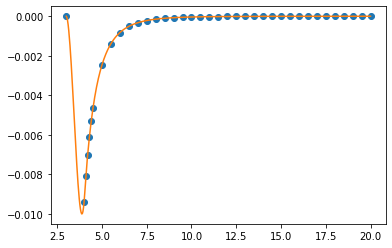

In [3]:
# Obtain the R6 baseline function

# Read data from .xml file and extract the distance-energy value.
tree = ET.parse('P_r6_innercut.xml')
root = tree.getroot()

r=[]
energy=[]
for i in root.iter('potential_pair'):
    for j in i.iter():
        if j.tag != 'potential_pair':
            r.append(float(j.attrib['r']))
            energy.append(float(j.attrib['E']))
        else:
            pass

energy=np.array(energy)/2
r=np.array(r)

r_new = np.linspace(2.8,20,500)


### base_func is the ultimate baseline function! Its domain is [3,20].

base_func = CubicSpline(r, energy, bc_type = 'clamped',extrapolate = False)
plt.plot(r, energy, 'o', r_new, base_func(r_new), '-')
plt.show()

In [4]:
def rmse2(actual, predicted):
    a=0
    n=len(actual)
    for i in np.arange(n):
        a+=np.power(actual[i]-predicted[i],2)
    return np.sqrt(a/n)

In [5]:
train_frames = ase.io.read("exfoliation_mbd_no_baseline.xyz", ":")
frames = ase.io.read("exfoliation_mbd_reference.xyz", ":")

train_energy = np.array([
    frame.info["energy"] for frame in train_frames
])

train_forces = np.vstack([
    frame.arrays["forces"] for frame in train_frames
])

test_energy = np.array([
    frame.info["energy"] for frame in frames
])

test_forces = np.vstack([
    frame.arrays["forces"] for frame in frames
])

In [6]:
hypers_rascaline = {
    "cutoff": 5.,
    "atomic_gaussian_width": 0.3,
    "max_radial": 10,
    "max_angular": 10,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 1.}},
    "gradients": True
}

In [7]:
calculator_sr = RascalineSphericalExpansion(hypers_rascaline)
descriptor_sr = calculator_sr.compute(train_frames)
test_sr = calculator_sr.compute(frames)

inv_srsr = compute_power_spectrum(descriptor_sr)
inv_test_sr = compute_power_spectrum(test_sr)

In [8]:
inv_srsr.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
inv_srsr.keys_to_samples('center_species')

inv_test_sr.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
inv_test_sr.keys_to_samples('center_species')

In [9]:
### Linear model
model = LinearModel(do_normalize=False, regularizer=[1.25e-4, 1.25e-4])
model.fit(inv_srsr, train_energy, train_forces)
pred_energy_srsr, pred_forces_srsr = model.predict(inv_test_sr, with_forces=True)

for i in tqdm(np.arange(len(frames))):
    pred_energy_srsr[i] += EF_baseline(frames[i], base_func, 20.)[0]
    pred_forces_srsr[8*i:8*(i+1),:] += EF_baseline(frames[i], base_func, 20.)[1]

test_energy_per_atom=[]
pred_energy_srsr_per_atom=[]

for i in np.arange(len(frames)):
    n_atoms = len(frames[i])
    test_energy_per_atom.append(test_energy[i]/n_atoms)
    pred_energy_srsr_per_atom.append(pred_energy_srsr[i]/n_atoms)

test_energy_per_atom=np.array(test_energy_per_atom)
pred_energy_srsr_per_atom=np.array(pred_energy_srsr_per_atom)

print('Energy RMSE (eV/atom) of the srsr model is:')
print(rmse2(test_energy_per_atom, pred_energy_srsr_per_atom))
print('Forces RMSE (eV/A) of the srsr model is:')
print(rmse2(test_forces.flatten(), pred_forces_srsr.flatten()))

100%|██████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]

Energy RMSE (eV/atom) of the srsr model is:
[0.00131]
Forces RMSE (eV/A) of the srsr model is:
0.006396407970628453


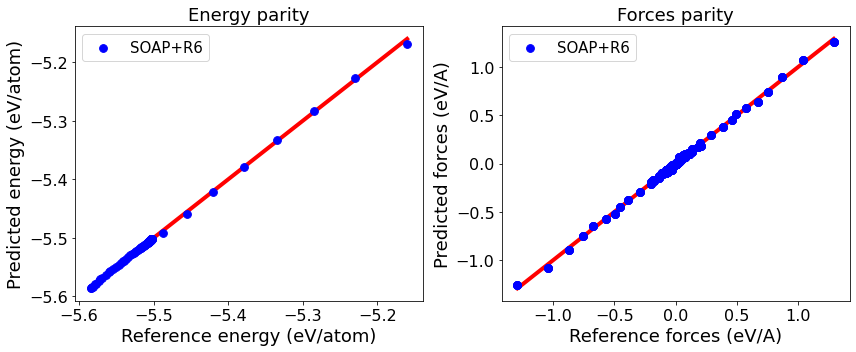

In [10]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
x = [test_energy_per_atom.min(), test_energy_per_atom.max()]
ax[0].set_title('Energy parity',fontsize=18)
ax[0].set_xlabel('Reference energy (eV/atom)',fontsize=18)
ax[0].set_ylabel('Predicted energy (eV/atom)',fontsize=18)
ax[0].tick_params(labelsize=16)
ax[0].plot(x, x, color="r",linewidth=4)
ax[0].scatter(test_energy_per_atom, pred_energy_srsr_per_atom,color='blue',label='SOAP+R6',zorder=3,s=60)
ax[0].legend(markerscale=1,fontsize=15)

xx = [test_forces.flatten().min(), test_forces.flatten().max()]
ax[1].set_title('Forces parity',fontsize=18)
ax[1].set_xlabel('Reference forces (eV/A)',fontsize=18)
ax[1].set_ylabel('Predicted forces (eV/A)',fontsize=18)
ax[1].tick_params(labelsize=16)
ax[1].plot(xx, xx, color="r",linewidth=4)
ax[1].scatter(test_forces.flatten(), pred_forces_srsr.flatten(),color='blue',label='SOAP+R6',zorder=3,s=60)
ax[1].legend(markerscale=1,fontsize=15)

plt.tight_layout()

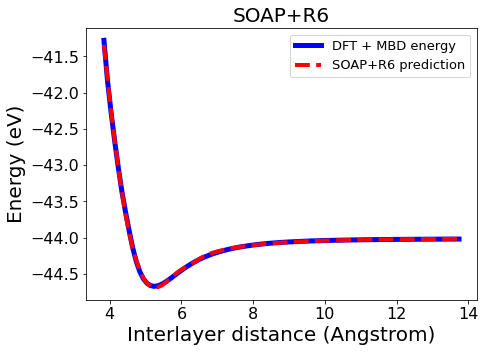

In [11]:
dist_list = []
error_forces = []

for i in np.arange(len(frames)):
    dist = frames[i].get_positions()[0,1]-frames[i].get_positions()[6,1]
    dist_list.append(dist)
    error = np.sqrt(np.sum(
        np.power( pred_forces_srsr[8*i:8*(i+1),1:3]-test_forces[8*i:8*(i+1),1:3],2)
    )/16)
    error_forces.append(error)

fig,ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Interlayer distance (Angstrom)',fontsize=20)
ax.set_ylabel('Energy (eV)',fontsize=20)
ax.tick_params(labelsize=16)
ax.set_title('SOAP+R6',fontsize=20)

ax.plot(dist_list, test_energy,'-',label='DFT + MBD energy',linewidth=5,color='blue')
ax.plot(dist_list, pred_energy_srsr,'--',label='SOAP+R6 prediction',linewidth=4,color='r')

ax.legend(markerscale=2,fontsize=13)